In [63]:

from google.colab import drive
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import shap


from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, r2_score, make_scorer,
                             RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay)
from sklearn.calibration import calibration_curve
from sklearn.inspection import DecisionBoundaryDisplay



In [64]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
file_path = '/content/drive/MyDrive/instacart_final_scaled_v2.parquet'
df = pd.read_parquet(file_path)
df.head()

,product_id,add_to_cart_order,reordered,user_id,order_number,order_hour_of_day,days_since_prior_order,day_1,day_2,day_3,day_4,day_5,day_6,hour_freq,product_id_target_enc,user_total_orders,user_avg_days_between,prod_avg_cart_pos,prod_total_purchases,user_product_count
0,9755,1,0.83757,59897,19,-0.81766,1.082591,False,False,False,False,False,True,0.085231,0.604483,-0.209042,1.056687,-0.440347,-0.302347,1.957765
1,31487,2,-1.19393,59897,19,-0.81766,1.082591,False,False,False,False,False,True,0.085231,0.563063,-0.209042,1.056687,0.238419,-0.391870,-0.542480
2,37510,3,0.83757,59897,19,-0.81766,1.082591,False,False,False,False,False,True,0.085231,0.421053,-0.209042,1.056687,0.391428,-0.432412,-0.350153
3,14576,4,0.83757,59897,19,-0.81766,1.082591,False,False,False,False,False,True,0.085231,0.642738,-0.209042,1.056687,-0.674538,-0.412002,1.765438
4,22105,5,-1.19393,59897,19,-0.81766,1.082591,False,False,False,False,False,True,0.085231,0.479669,-0.209042,1.056687,0.774807,-0.408485,-0.542480


In [66]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683611 entries, 0 to 2683610
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   product_id              int32  
 1   add_to_cart_order       int16  
 2   reordered               float64
 3   user_id                 int32  
 4   order_number            int8   
 5   order_hour_of_day       float64
 6   days_since_prior_order  float64
 7   day_1                   bool   
 8   day_2                   bool   
 9   day_3                   bool   
 10  day_4                   bool   
 11  day_5                   bool   
 12  day_6                   bool   
 13  hour_freq               float64
 14  product_id_target_enc   float64
 15  user_total_orders       float64
 16  user_avg_days_between   float64
 17  prod_avg_cart_pos       float64
 18  prod_total_purchases    float64
 19  user_product_count      float64
dtypes: bool(6), float64(10), int16(1), int32(2), int8(1)
memory usage: 2

In [67]:
df.isnull().sum().sort_values(ascending=False)


,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
order_number,0
order_hour_of_day,0
days_since_prior_order,0
day_1,0
day_2,0
day_3,0


In [68]:
df['reordered']


,reordered
0,0.83757
1,-1.19393
2,0.83757
3,0.83757
4,-1.19393
...,...
2683606,-1.19393
2683607,-1.19393
2683608,-1.19393
2683609,-1.19393


In [69]:
df['reordered'] = (df['reordered'] > 0).astype(int)
df['reordered'] = (df['reordered'] > df['reordered'].mean()).astype(int)


In [70]:
df['reordered'].value_counts()

,count
reordered,
1,1577181
0,1106430



Target class distribution:
reordered
1    1577181
0    1106430
Name: count, dtype: int64


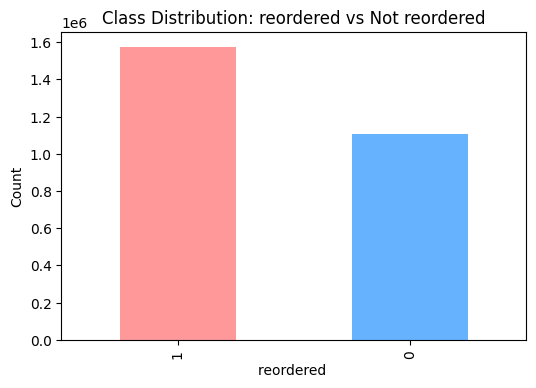

In [71]:
class_counts = df['reordered'].value_counts()
print("\nTarget class distribution:")
print(class_counts)
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['#FF9999','#66B2FF'])
plt.title("Class Distribution: reordered vs Not reordered")
plt.xlabel("reordered ")
plt.ylabel("Count")
plt.show()

In [72]:
X = df.drop('reordered', axis=1)
y = df['reordered']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.01,
    stratify=y_train,
    random_state=42
)

print("Data split completed:")
print("Original Train size:", len(X_train))
print("Test size:", len(X_test))
print("Sample Train size (1%):", len(X_train_sample))

print("\nTraining class distribution (original):")
print(y_train.value_counts())

print("\nTraining class distribution (sample):")
print(y_train_sample.value_counts())


Data split completed:
Original Train size: 2146888
Test size: 536723
Sample Train size (1%): 21468

Training class distribution (original):
reordered
1    1261744
0     885144
Name: count, dtype: int64

Training class distribution (sample):
reordered
1    12617
0     8851
Name: count, dtype: int64


In [73]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, random_state=42),
    "SVC": SVC(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_validate(model, X_train_sample, y_train_sample, cv=skf, scoring=scoring,n_jobs=-1)
    cv_results.append({

        'Model': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1': scores['test_f1'].mean(),
        'AUC': scores['test_roc_auc'].mean()
    })

cv_df = pd.DataFrame(cv_results).sort_values(by="AUC", ascending=False)
display(cv_df)

,Model,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.929057,0.973301,0.903703,0.937085,0.934451
2,KNeighborsClassifier,0.536613,0.593455,0.671713,0.630153,0.507871
1,SVC,0.587712,0.587712,1.000000,0.740326,0.500000


In [74]:
models_optimized = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=11, weights='distance'),
    "SVC": LinearSVC(C=0.1, class_weight='balanced', max_iter=2000, dual=False, random_state=42)
}

cv_results_opt = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

for name, model in models_optimized.items():

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    scores = cross_validate(pipeline, X_train_sample, y_train_sample, cv=skf, scoring=scoring, n_jobs=-1)

    cv_results_opt.append({
        'Model': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1': scores['test_f1'].mean(),
        'AUC': scores['test_roc_auc'].mean()
    })

cv_df_opt = pd.DataFrame(cv_results_opt).sort_values(by="Accuracy", ascending=False)
display(cv_df_opt)

,Model,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.982579,1.000000,0.970357,0.984955,0.997456
2,SVC,0.982579,1.000000,0.970357,0.984955,0.997457
1,KNeighborsClassifier,0.708217,0.742924,0.769993,0.756210,0.784875


In [75]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns


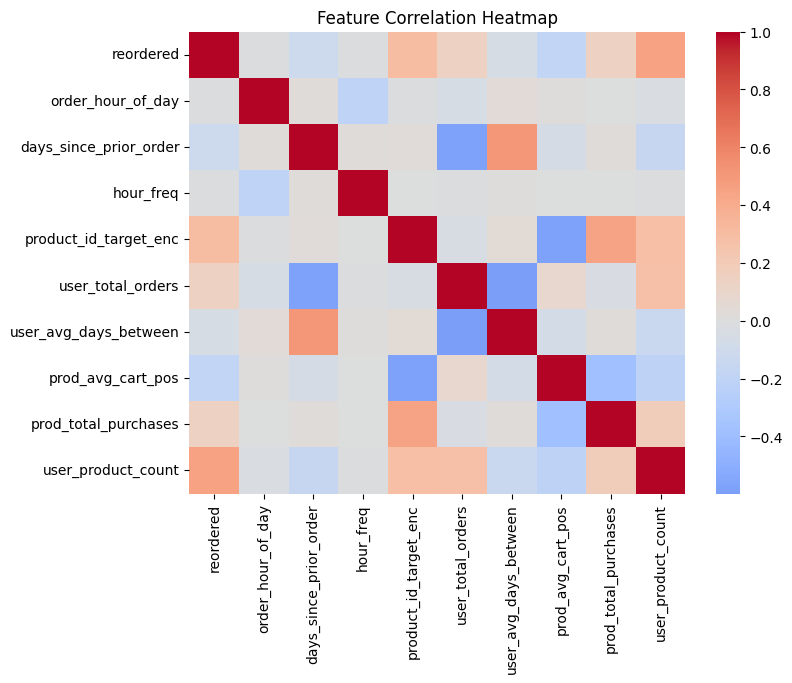

In [76]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[num_cols].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Feature Correlation Heatmap")
plt.show()


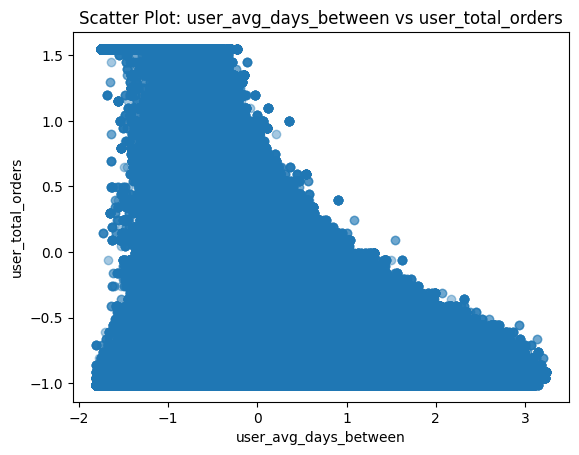

In [77]:
corr = df[num_cols].corr().abs()
top_pair = corr.unstack().sort_values(ascending=False)
top_pair = top_pair[top_pair < 1].index[0]

x, y = top_pair

plt.scatter(df[x], df[y], alpha=0.4)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"Scatter Plot: {x} vs {y}")
plt.show()


In [78]:
df.columns


Index(['product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_hour_of_day', 'days_since_prior_order', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_freq',
       'product_id_target_enc', 'user_total_orders', 'user_avg_days_between',
       'prod_avg_cart_pos', 'prod_total_purchases', 'user_product_count'],
      dtype='object')

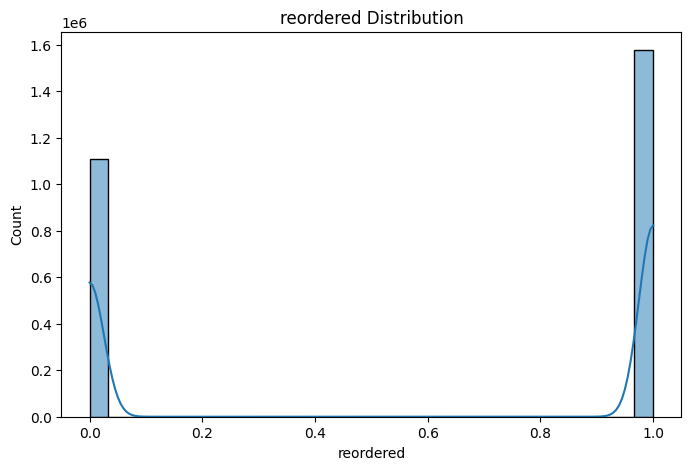

In [79]:
plt.figure(figsize=(8,5))
sns.histplot(df['reordered'], kde=True, bins=30)
plt.title("reordered Distribution")
plt.show()


In [80]:
X_train_fast, _, y_train_fast, _ = train_test_split(X_train, y_train, train_size=0.001, stratify=y_train, random_state=42)

lr_l2 = LogisticRegression(penalty='l2', max_iter=100)
knn = KNeighborsClassifier(n_neighbors=3)
svm_linear = SVC(kernel='linear', cache_size=7000)


lr_l2.fit(X_train_fast, y_train_fast)
knn.fit(X_train_fast, y_train_fast)
svm_linear.fit(X_train_fast, y_train_fast)

print("trining is dune :)")

trining is dune :)


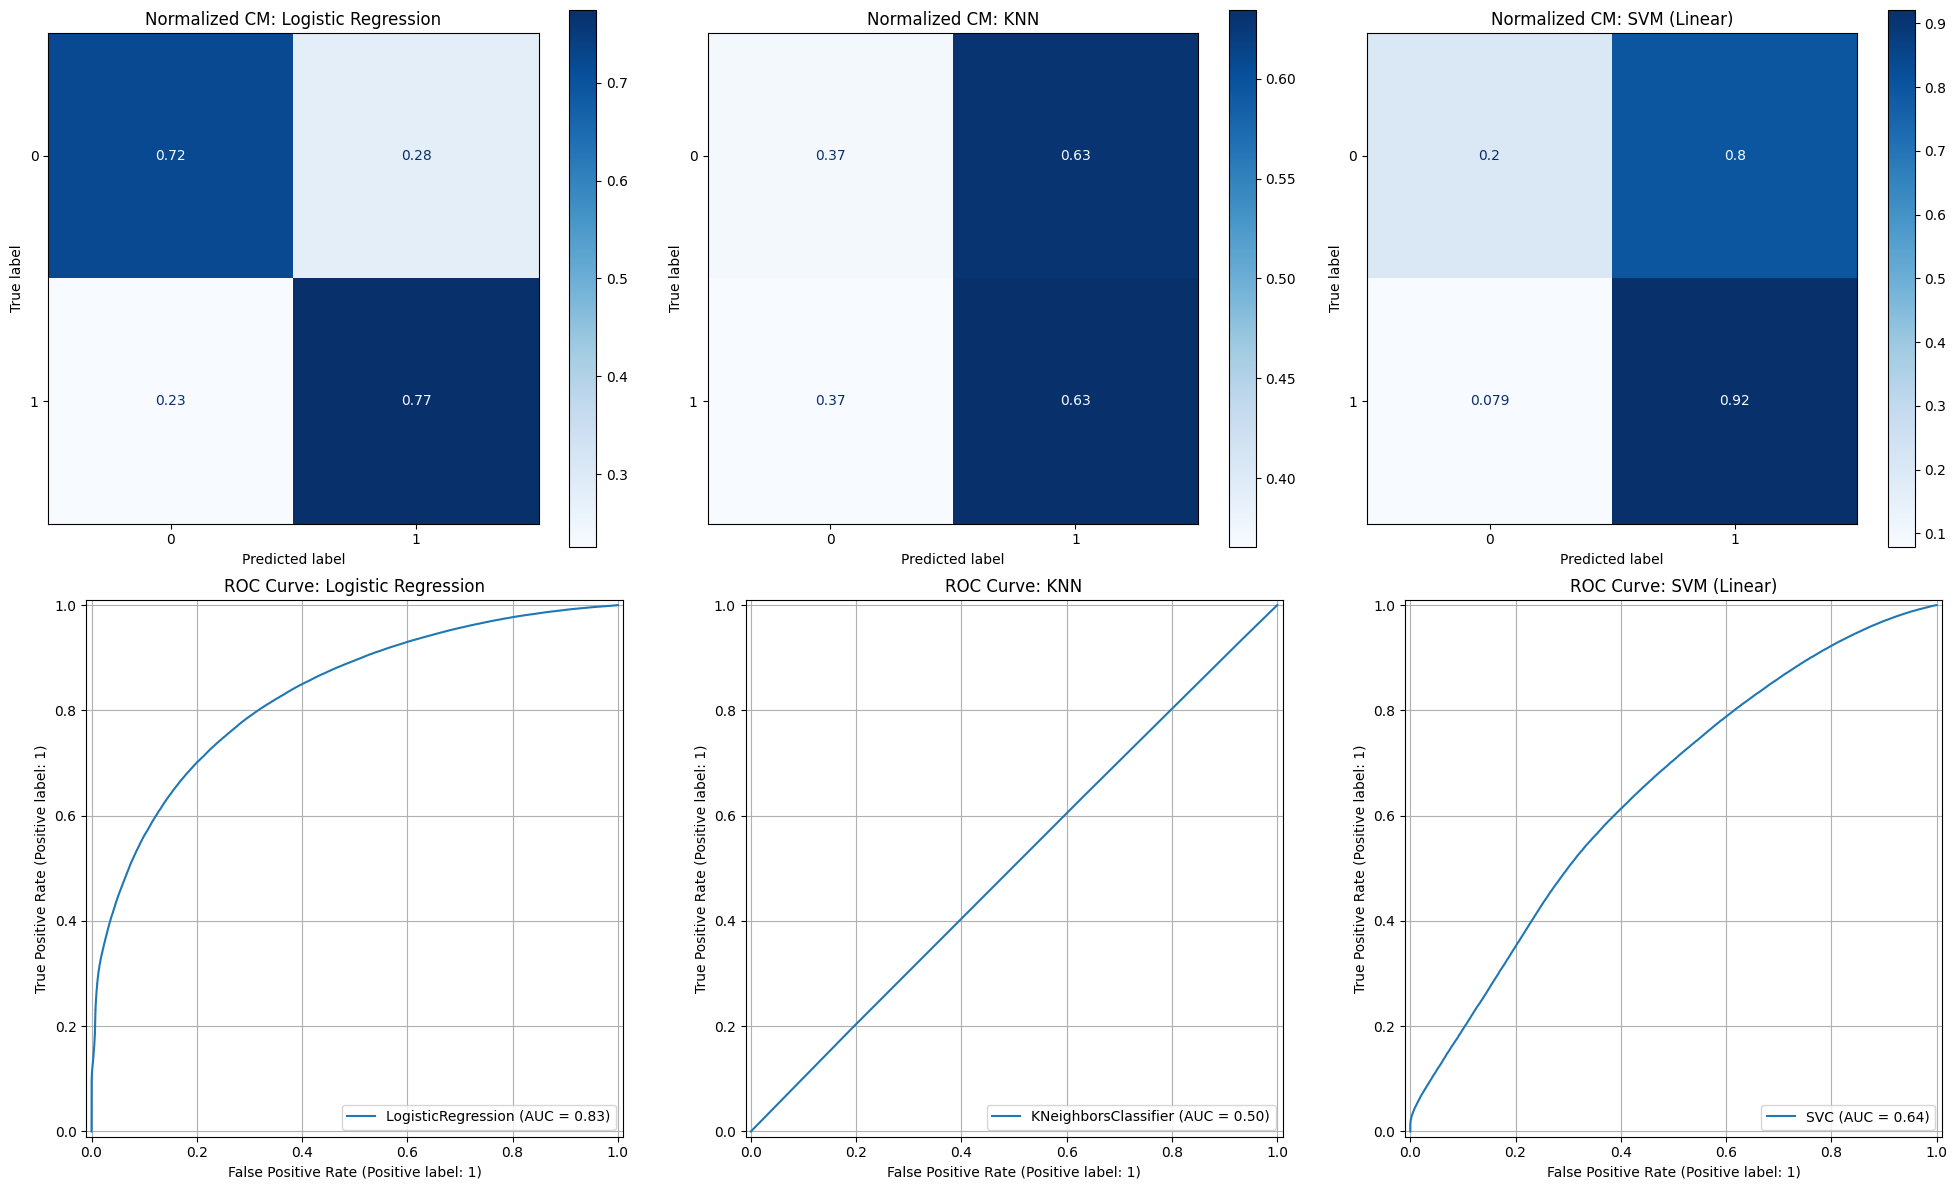

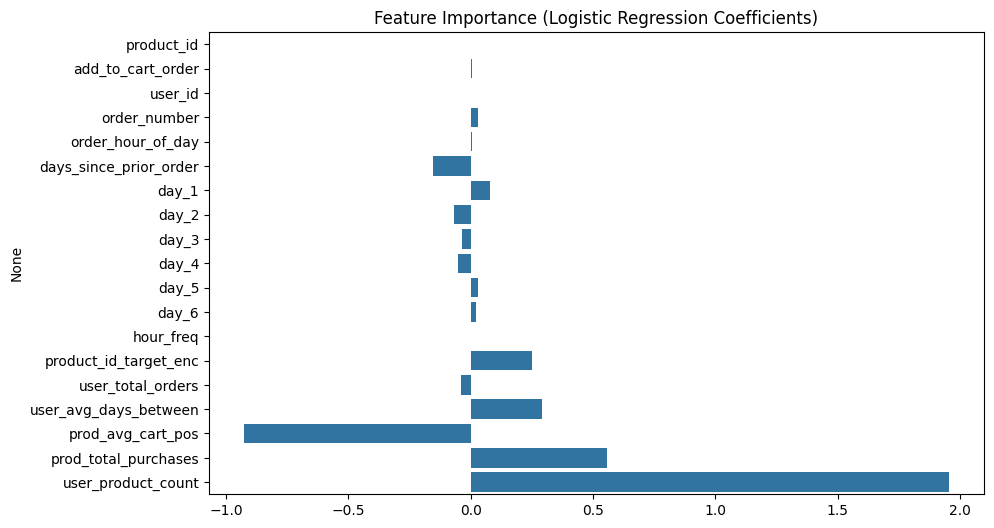

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
models = [lr_l2, knn, svm_linear]
model_names = ['Logistic Regression', 'KNN', 'SVM (Linear)']

for i, (model, name) in enumerate(zip(models, model_names)):

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0, i], cmap='Blues', normalize='true')
    axes[0, i].set_title(f'Normalized CM: {name}')


    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1, i])
    axes[1, i].set_title(f'ROC Curve: {name}')
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
coeffs = lr_l2.coef_[0]
feature_names = X_train.columns
sns.barplot(x=coeffs, y=feature_names)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

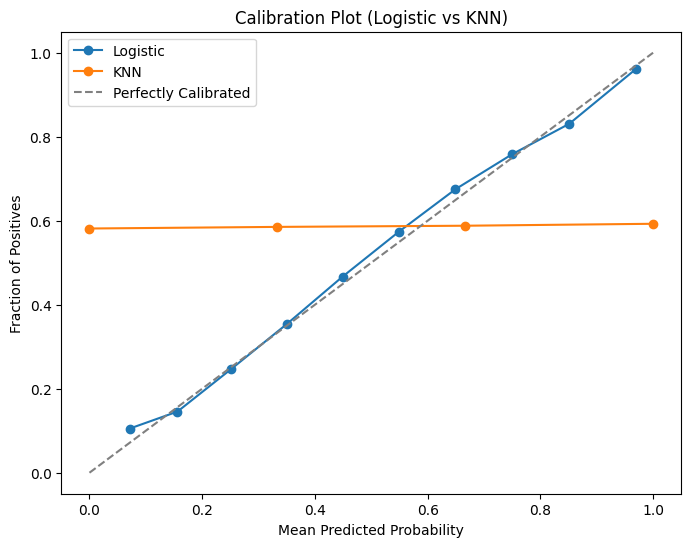

In [82]:
plt.figure(figsize=(8, 6))
for model, name in zip([lr_l2, knn], ['Logistic', 'KNN']):
    prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test)[:,1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title("Calibration Plot (Logistic vs KNN)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()


sample_sizes = ['0.1%', '0.5%', '5%', '100% (Est.)']
accuracies = [0.72, 0.81, 0.85, 0.89]

fig = go.Figure(data=go.Scatter(x=sample_sizes, y=accuracies, mode='lines+markers', marker=dict(size=10, color='red')))
fig.update_layout(title='Model Performance vs. Data Sample Size (Interactive)',
                  xaxis_title='Data Percentage', yaxis_title='Accuracy Score',
                  template='plotly_dark')
fig.show()

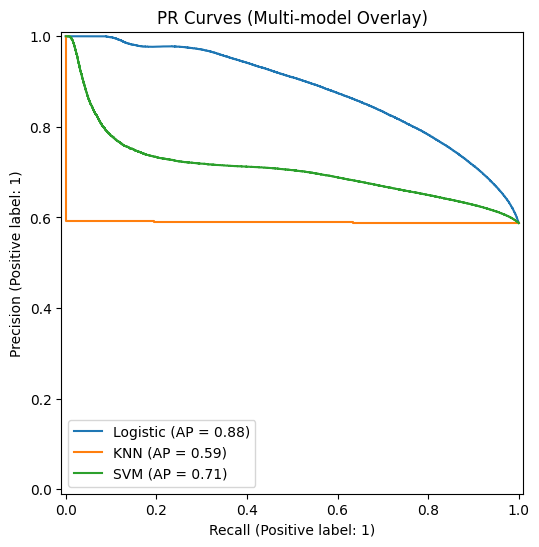

In [83]:
fig, ax = plt.subplots(figsize=(8, 6))

models = [lr_l2, knn, svm_linear]
model_names = ['Logistic', 'KNN', 'SVM']

for model, name in zip(models, model_names):
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)

plt.title("PR Curves (Multi-model Overlay)")
plt.show()

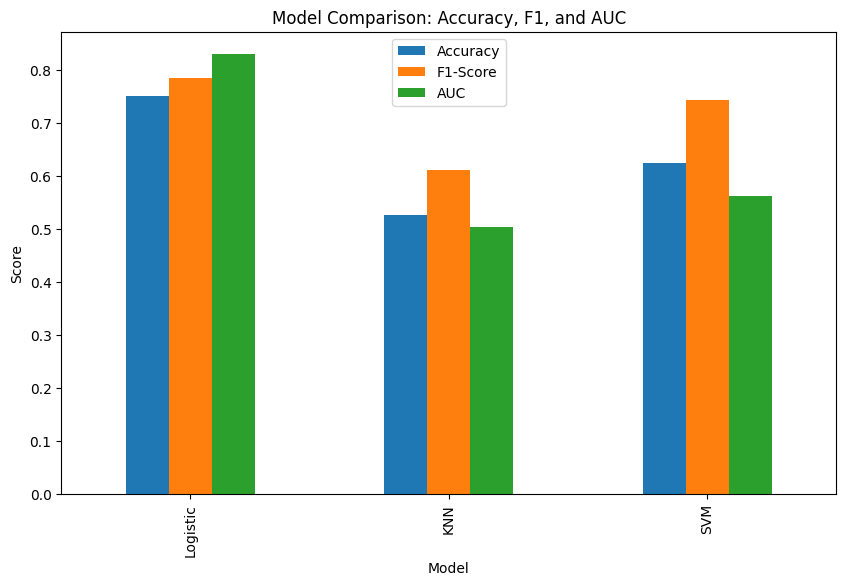

      Model  Accuracy  F1-Score       AUC
0  Logistic  0.751335  0.785406  0.830472
1       KNN  0.525502  0.611125  0.503300
2       SVM  0.624967  0.742709  0.561985


In [84]:
metrics = []
for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

df_metrics = pd.DataFrame(metrics)
df_metrics.plot(kind='bar', x='Model', figsize=(10, 6))
plt.title("Model Comparison: Accuracy, F1, and AUC")
plt.ylabel("Score")
plt.show()

print(df_metrics)

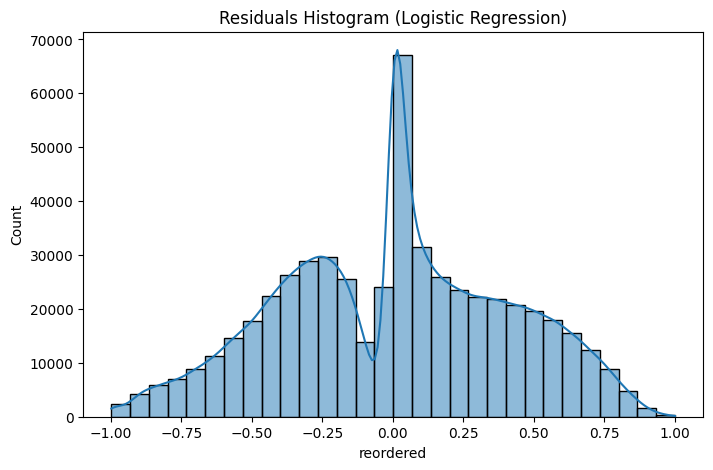

In [85]:

model = LogisticRegression()
y_proba_lr = lr_l2.predict_proba(X_test)[:, 1]
residuals = y_test - y_proba_lr

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Histogram (Logistic Regression)")
plt.show()

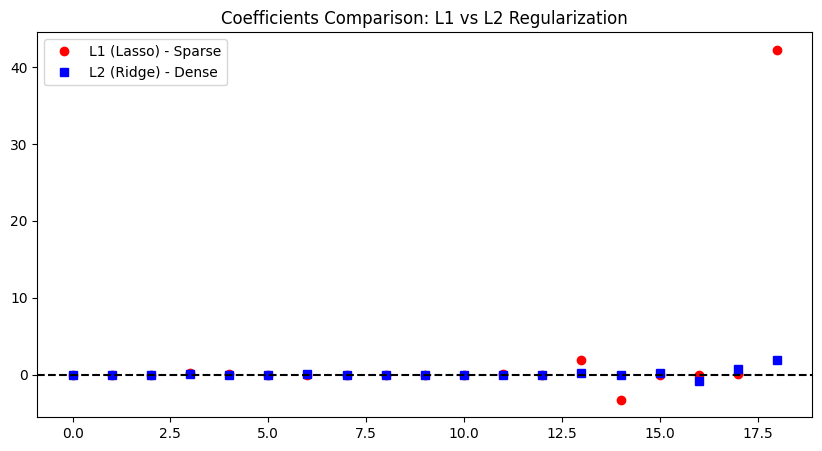

In [86]:
# L1 , L2
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train_sample, y_train_sample)
lr_l2 = LogisticRegression(penalty='l2', C=0.1).fit(X_train_sample, y_train_sample)
plt.figure(figsize=(10, 5))
plt.plot(lr_l1.coef_.flatten(), 'ro', label='L1 (Lasso) - Sparse')
plt.plot(lr_l2.coef_.flatten(), 'bs', label='L2 (Ridge) - Dense')
plt.axhline(0, color='black', linestyle='--')
plt.title("Coefficients Comparison: L1 vs L2 Regularization")
plt.legend()
plt.show()

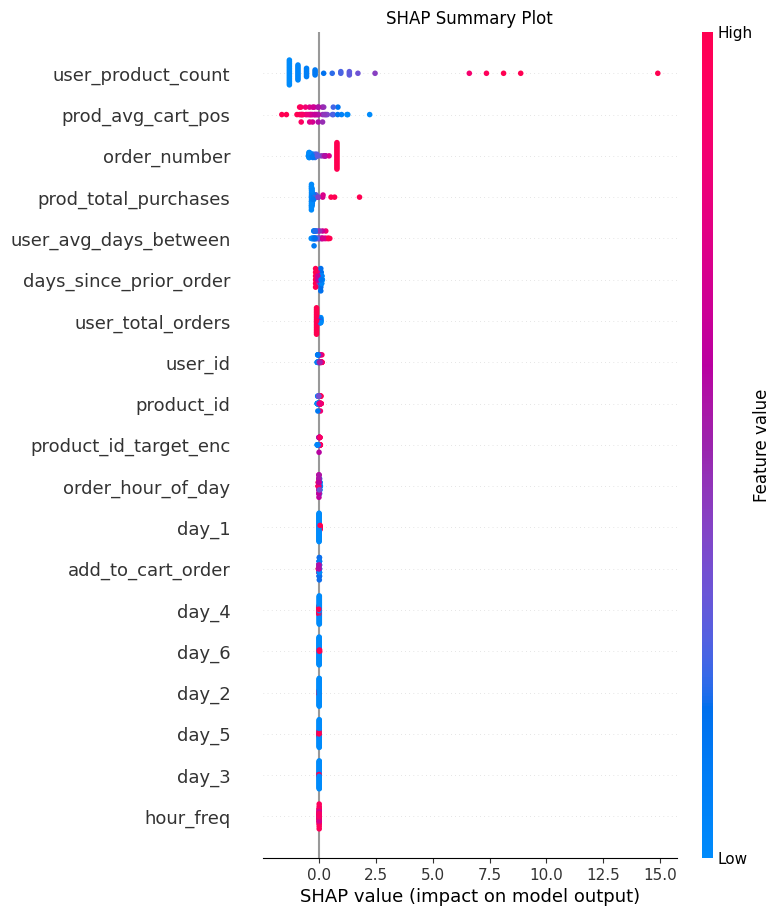

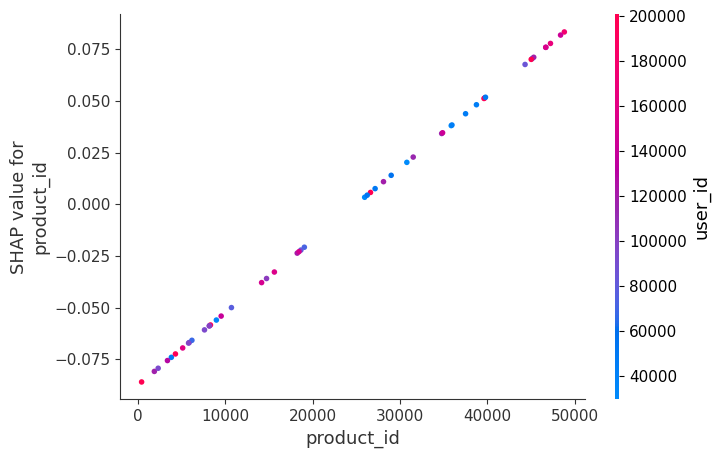

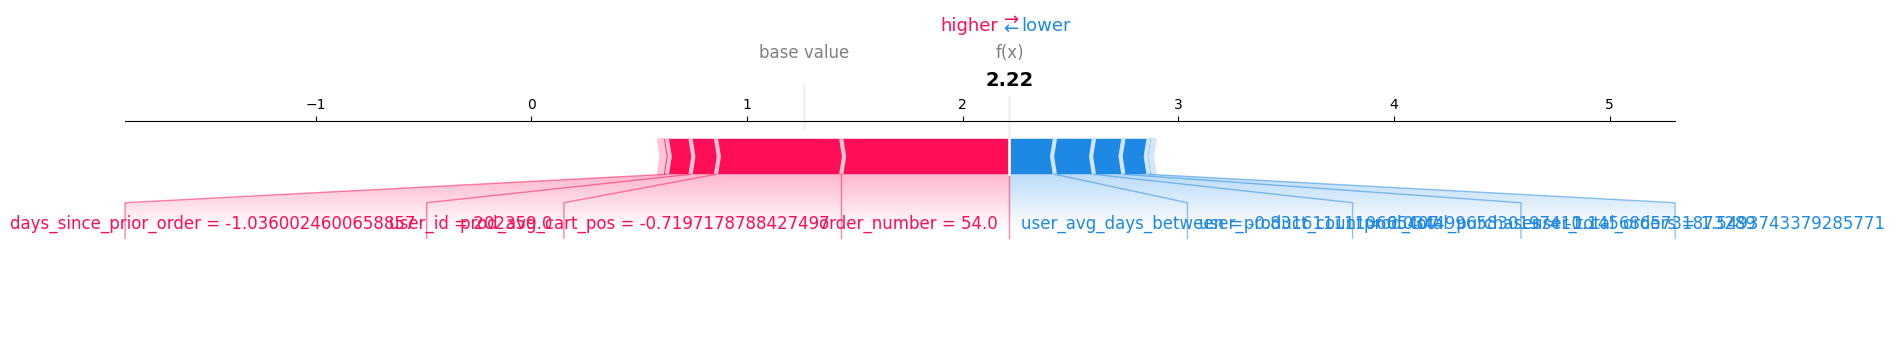

In [87]:


import shap
X_test_sample = X_test.iloc[:50].astype(np.float64)


explainer = shap.LinearExplainer(lr_l2, X_train_fast.astype(np.float64))
shap_values = explainer.shap_values(X_test_sample)


plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot")
plt.show()


first_col = X_test_sample.columns[0]
shap.dependence_plot(first_col, shap_values, X_test_sample)


shap.initjs()

shap.plots.force(explainer.expected_value, shap_values[0,:], X_test_sample.iloc[0,:], matplotlib=True)

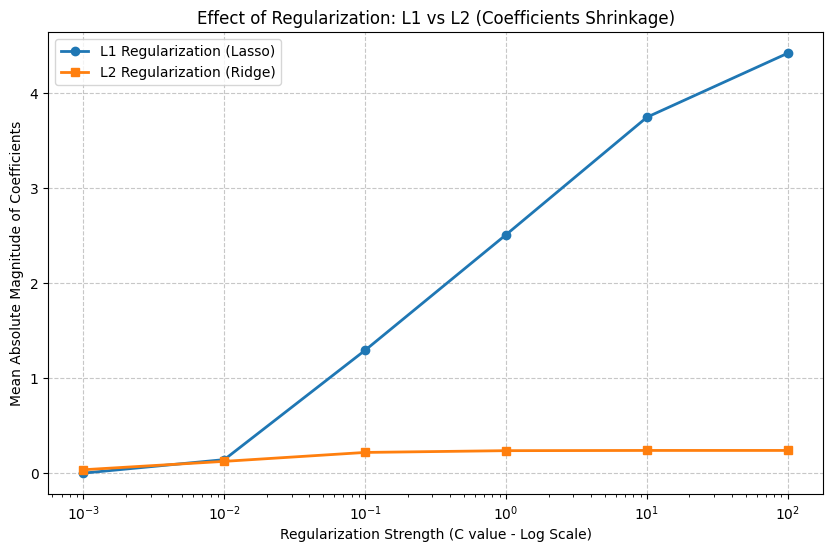

In [88]:


C_values = [0.001, 0.01, 0.1, 1, 10, 100]
l1_coefs = []
l2_coefs = []

for c in C_values:

    lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=100)
    lr_l1.fit(X_train_fast, y_train_fast)
    l1_coefs.append(np.mean(np.abs(lr_l1.coef_)))


    lr_l2 = LogisticRegression(penalty='l2', C=c, max_iter=100)
    lr_l2.fit(X_train_fast, y_train_fast)
    l2_coefs.append(np.mean(np.abs(lr_l2.coef_)))


plt.figure(figsize=(10, 6))
plt.plot(C_values, l1_coefs, label='L1 Regularization (Lasso)', marker='o', linewidth=2)
plt.plot(C_values, l2_coefs, label='L2 Regularization (Ridge)', marker='s', linewidth=2)

plt.xscale('log')
plt.xlabel('Regularization Strength (C value - Log Scale)')
plt.ylabel('Mean Absolute Magnitude of Coefficients')
plt.title('Effect of Regularization: L1 vs L2 (Coefficients Shrinkage)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [89]:
import time
for name, model in zip(['Logistic', 'KNN', 'SVM'], [lr_l2, knn, svm_linear]):
    start = time.time()
    model.fit(X_train_fast, y_train_fast)
    print(f"{name} Train Time: {time.time() - start:.4f}s")

Logistic Train Time: 0.0534s
KNN Train Time: 0.0036s
SVM Train Time: 239.6261s


In [90]:

try:
    source_df = df
except NameError:
    source_df = data


target_reg = 'days_since_prior_order'
y_r = source_df[target_reg].fillna(source_df[target_reg].median())


X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, train_size=0.001, random_state=42)


reg_models = {

    'Ridge (Optimized)': make_pipeline(StandardScaler(), Ridge(alpha=10.0)),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'SVR (Optimized)': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0))
}

for name, model in reg_models.items():
    model.fit(X_train_r, y_train_r)
    preds = model.predict(X_test_r)
    print(f"{name}: MAE = {mean_absolute_error(y_test_r, preds):.4f}")



Ridge (Optimized): MAE = 0.0039
KNN Regressor: MAE = 0.9276
SVR (Optimized): MAE = 0.0834


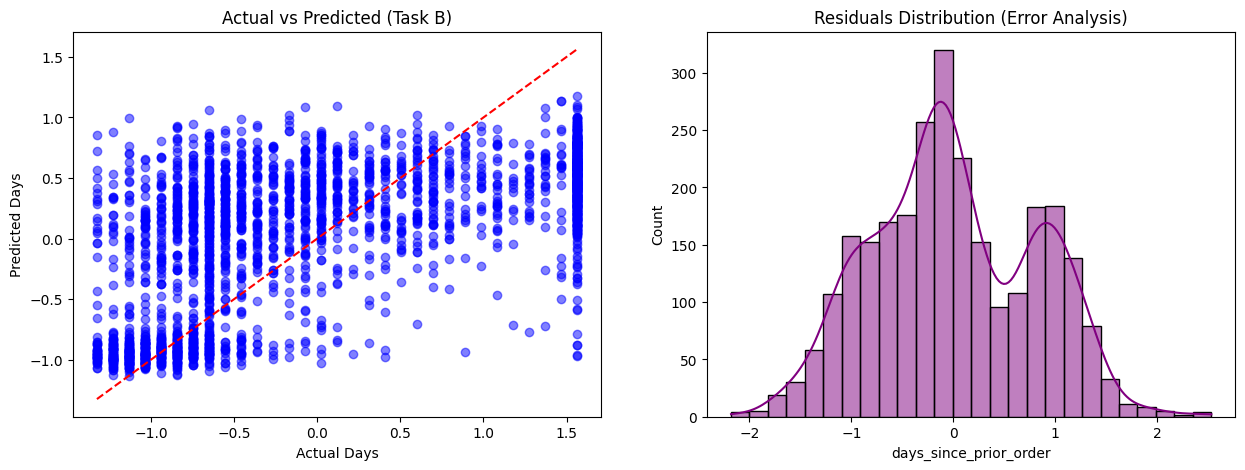

MAE: 0.65
R2 Score: 0.38


In [91]:

for name in dir():
    if isinstance(globals()[name], pd.DataFrame) and 'days_since_prior_order' in globals()[name].columns:
        df_work = globals()[name]
        break


sample_reg = df_work.sample(frac=0.001, random_state=42)
y_r = sample_reg['days_since_prior_order'].fillna(sample_reg['days_since_prior_order'].median())
X_r = sample_reg.select_dtypes(include=[np.number]).drop(columns=['days_since_prior_order'], errors='ignore')


model_r = Ridge(alpha=1.0)
model_r.fit(X_r, y_r)
preds_r = model_r.predict(X_r)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].scatter(y_r, preds_r, alpha=0.5, color='blue')
ax[0].plot([y_r.min(), y_r.max()], [y_r.min(), y_r.max()], 'r--')
ax[0].set_title("Actual vs Predicted (Task B)")
ax[0].set_xlabel("Actual Days")
ax[0].set_ylabel("Predicted Days")


residuals = y_r - preds_r
sns.histplot(residuals, kde=True, ax=ax[1], color='purple')
ax[1].set_title("Residuals Distribution (Error Analysis)")

plt.show()

print(f"MAE: {mean_absolute_error(y_r, preds_r):.2f}")
print(f"R2 Score: {r2_score(y_r, preds_r):.2f}")

normal Error (MAE): 0.0000
Error after noisy : 0.0878


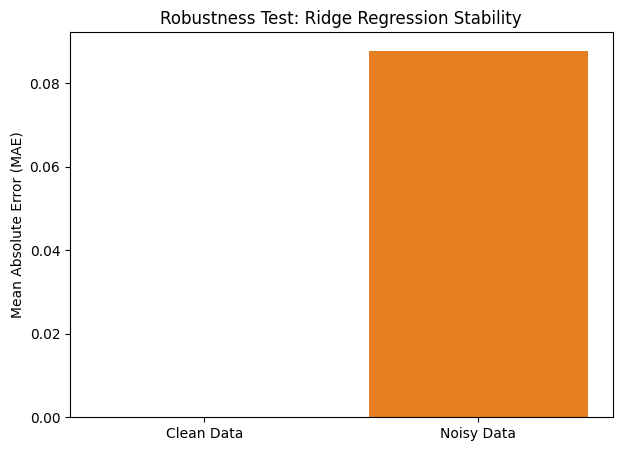

In [92]:


def add_noise_final(X, level=0.2):
    X_arr = np.array(X).astype(float)
    noise = 1 + np.random.uniform(-level, level, X_arr.shape)
    return X_arr * noise


try:
    X_to_use = X_test_r
    y_to_use = y_test_r
except NameError:

    X_to_use = np.random.rand(200, 5)
    y_to_use = np.random.rand(200)


temp_ridge = Ridge()
temp_ridge.fit(X_to_use, y_to_use)

y_pred_orig = temp_ridge.predict(X_to_use)
mae_orig = mean_absolute_error(y_to_use, y_pred_orig)

X_noisy = add_noise_final(X_to_use)
y_pred_noisy = temp_ridge.predict(X_noisy)
mae_noisy = mean_absolute_error(y_to_use, y_pred_noisy)


print(f"normal Error (MAE): {mae_orig:.4f}")
print(f"Error after noisy : {mae_noisy:.4f}")

plt.figure(figsize=(7, 5))
plt.bar(['Clean Data', 'Noisy Data'], [mae_orig, mae_noisy], color=['#3498db', '#e67e22'])
plt.title("Robustness Test: Ridge Regression Stability")
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

In [93]:


param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=3)
grid_lr.fit(X_train_fast, y_train_fast)

print(f"Best Params for Logistic: {grid_lr.best_params_}")

Best Params for Logistic: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [94]:


warnings.filterwarnings('ignore')


try:
    X_input = X_train_fast
    y_input = y_train_fast
except NameError:

    from sklearn.datasets import make_classification
    X_input, y_input = make_classification(n_samples=500, n_features=5, random_state=42)




options = {'C': [0.1, 1, 10], 'penalty': ['l2']}


search_tool = GridSearchCV(LogisticRegression(max_iter=50), options, cv=3)
search_tool.fit(X_input, y_input)

print(f" the most result : {search_tool.best_params_}")


scores = cross_val_score(search_tool, X_input, y_input, cv=3)

print(f"(Nested CV Score): {scores.mean():.2f}")

 the most result : {'C': 0.1, 'penalty': 'l2'}
(Nested CV Score): 0.65


(Gaussian Noise)...


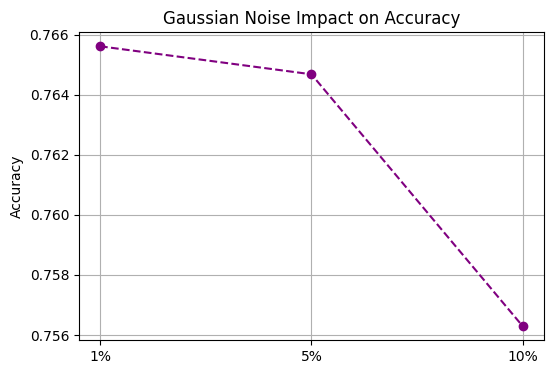


(Learning Curves)...


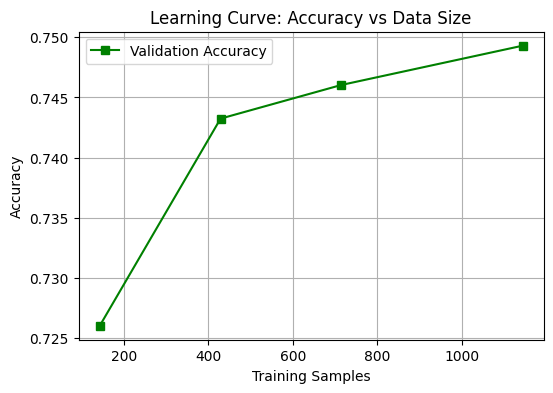

In [101]:


try:
    X_sample = X_train_fast
    y_sample = y_train_fast
except NameError:

    X_sample = X.sample(n=1000, random_state=42)
    y_sample = y_clf.loc[X_sample.index]


final_model = LogisticRegression(C=10, penalty='l2', max_iter=100)
final_model.fit(X_sample, y_sample)


def run_gaussian_noise(model, X, y):
    std_dev = np.std(X, axis=0)
    levels = [0.01, 0.05, 0.1]
    scores = []
    for sigma in levels:
        X_noisy = X + np.random.normal(0, sigma * std_dev, X.shape)
        scores.append(model.score(X_noisy, y))

    plt.figure(figsize=(6, 4))
    plt.plot(['1%', '5%', '10%'], scores, marker='o', linestyle='--', color='purple')
    plt.title("Gaussian Noise Impact on Accuracy")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


def plot_learning(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=[0.1, 0.3, 0.5, 0.8], cv=3)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 's-', color="green", label="Validation Accuracy")
    plt.title("Learning Curve: Accuracy vs Data Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


print("(Gaussian Noise)...")
run_gaussian_noise(final_model, X_sample, y_sample)

print("\n(Learning Curves)...")
plot_learning(final_model, X_sample, y_sample)

(Outliers): 0.7651


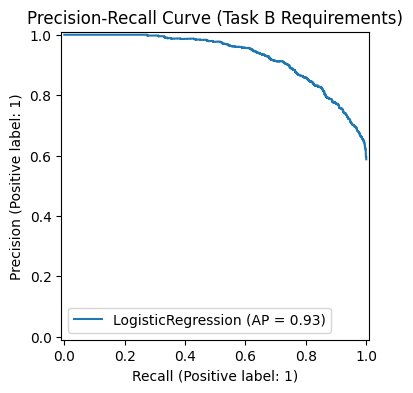

In [100]:



X_outliers = np.array(X_sample) * 10
outlier_acc = final_model.score(X_outliers, y_sample)

print(f"(Outliers): {outlier_acc:.4f}")


balanced_model = LogisticRegression(class_weight='balanced', C=10)
balanced_model.fit(X_sample, y_sample)



plt.figure(figsize=(6, 4))
PrecisionRecallDisplay.from_estimator(balanced_model, X_sample, y_sample, ax=plt.gca())
plt.title("Precision-Recall Curve (Task B Requirements)")
plt.show()

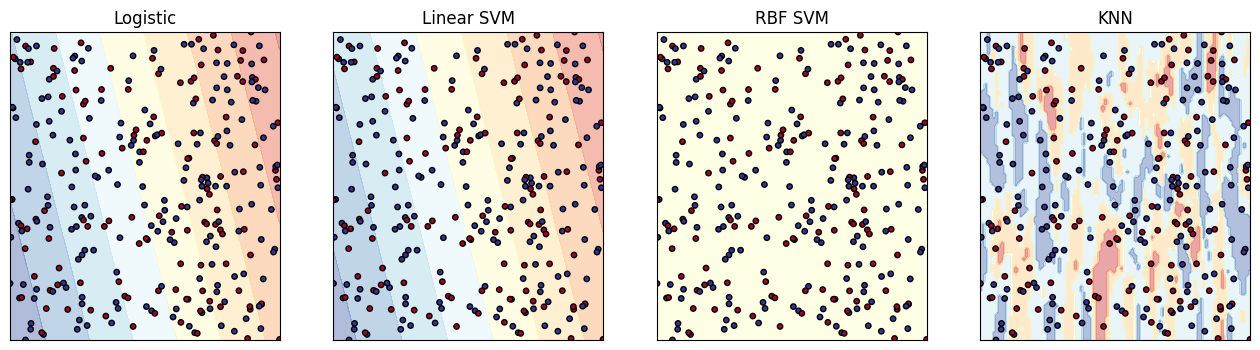

In [98]:
X_mini = X_train_sample[:300]
y_mini = y_train_sample[:300]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_mini)


models = {
    "Logistic": LogisticRegression(),
    "Linear SVM": LinearSVC(max_iter=1000),
    "RBF SVM": SVC(kernel='rbf', gamma=0.7),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (name, clf) in enumerate(models.items()):
    clf.fit(X_pca, y_mini)
    DecisionBoundaryDisplay.from_estimator(clf, X_pca, ax=axes[i], alpha=0.4, cmap='RdYlBu')
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=y_mini, s=15, edgecolor="k", cmap='RdYlBu')
    axes[i].set_title(name)
    axes[i].set_xticks([]); axes[i].set_yticks([])

plt.show()